In [1]:
# !pip install SPARQLWrapper
import json, requests, xml
from xml.dom import minidom
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import rdflib
import urllib
from matplotlib.pyplot import figure


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\rdflib_jsonld\__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(


In [2]:
def load_dataframe( query_response ):
  processed_results = json.load(query_response)
  cols = processed_results['head']['vars']
  out = []
  for row in processed_results['results']['bindings']:
     item = []
     for c in cols:
         item.append(row.get(c, {}).get('value'))
     out.append(item)
  df = pd.DataFrame(out, columns=cols)
  return df


# FedEO API Tutorial - PART 3: SPARQL Online Demonstrator  
 This tutorial is part of a series of tutorials covering related subjects:                  
 * [FedEO API Tutorial - PART 1: OpenSearch and API Features](tutorial-1-api.ipynb)
 * [FedEO API Tutorial - PART 2: STAC](tutorial-2-stac.ipynb)
 * FedEO API Tutorial - PART 3: SPARQL Online
 * [FedEO API Tutorial - PART 4: SPARQL Offline](tutorial-4-sparql.ipynb)


<a name='Overview'></a>     
## Overview  
 The different parts covered in this Notebook are:    
 * [Collections](#Collections) 
 * [Services](#Services)
 * [Granules](#Granules)       
 
 
 The different SPARQL query forms used include:        
 
 * SELECT - See https://www.w3.org/TR/rdf-sparql-query/#select
 * DESCRIBE - See https://www.w3.org/TR/rdf-sparql-query/#describe
       


<a name='Collections'></a>     
## Collections   


### Collections : Search by identifier  
**Example: 2**  
>  Return @id, name, instrument name, keywords.  
 OK  


In [3]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?name ?kw ?ins 
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Collection>.  
  ?p schema:identifier "TropForest".      
  ?p schema:name ?name.
  ?p schema:potentialAction/schema:instrument/schema:name ?ins.
  ?p schema:keywords ?kw. 
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,name,kw,ins
0,https://eovoc.spacebel.be/collections/series/i...,"TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...",https://gcmd.earthdata.nasa.gov/kms/concept/a9...,AVNIR-2
1,https://eovoc.spacebel.be/collections/series/i...,"TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...",https://gcmd.earthdata.nasa.gov/kms/concept/46...,AVNIR-2
2,https://eovoc.spacebel.be/collections/series/i...,"TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...",https://gcmd.earthdata.nasa.gov/kms/concept/6a...,AVNIR-2
3,https://eovoc.spacebel.be/collections/series/i...,"TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...",https://gcmd.earthdata.nasa.gov/kms/concept/c7...,AVNIR-2
4,https://eovoc.spacebel.be/collections/series/i...,"TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...",https://earth.esa.int/concept/agriculture,AVNIR-2


### Collections : Search by keyword URI  
**Example: 3**  
>  Return @id, name, identifier, instrument name, keywords.  
 OK  


In [4]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?name ?identifier ?ins 
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Collection>.       
  ?p schema:name ?name.
  ?p schema:identifier ?identifier.
  ?p schema:potentialAction/schema:instrument/schema:name ?ins.
  ?p schema:keywords <https://earth.esa.int/concept/forestry>. 
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,name,identifier,ins
0,https://eovoc.spacebel.be/collections/series/i...,Landsat 8 OLI-TIRS European Coverage,LANDSAT.OLI-TIRS.L1T_L1GT,TIRS
1,https://eovoc.spacebel.be/collections/series/i...,Landsat 8 OLI-TIRS European Coverage,LANDSAT.OLI-TIRS.L1T_L1GT,Landsat-8
2,https://eovoc.spacebel.be/collections/series/i...,GEOSAT-2 full archive and tasking,Geosat-2.Full.archive.and.tasking,HiRAIS
3,https://eovoc.spacebel.be/collections/series/i...,GEOSAT-2 full archive and tasking,Geosat-2.Full.archive.and.tasking,Deimos-2
4,https://eovoc.spacebel.be/collections/series/i...,WorldView-1 full archive and tasking,WorldView-1.full.archive.and.tasking,WV60
5,https://eovoc.spacebel.be/collections/series/i...,WorldView-1 full archive and tasking,WorldView-1.full.archive.and.tasking,WorldView-1
6,https://eovoc.spacebel.be/collections/series/i...,Alos African Coverage ESA archive,ALOS,PRISM
7,https://eovoc.spacebel.be/collections/series/i...,Alos African Coverage ESA archive,ALOS,ALOS-1
8,https://eovoc.spacebel.be/collections/series/i...,ICEYE full archive and tasking,ICEYE,X-SAR
9,https://eovoc.spacebel.be/collections/series/i...,ICEYE full archive and tasking,ICEYE,ICEYE


### Collections : Search by keyword, instrument  
**Example: 4**  
>  Return @id, name  
 OK  


In [5]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?name  
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Collection>.       
  ?p schema:name ?name.
  ?p schema:potentialAction/schema:instrument/schema:name "HRV".
  ?p schema:keywords "Agriculture" 
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,name
0,https://eovoc.spacebel.be/collections/series/i...,SPOT1-5 ESA archive


### Collections : Distributed request finding collections matching INSPIRE Theme.  
**Example: 5**  
>  Without INSPIRE keywords being present in the catalogue.  
    


In [6]:
q="""

PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX schema: <https://schema.org/>

SELECT ?entity ?name
WHERE
{
  
  ?entity  skos:inScheme <https://earth.esa.int/concepts/concept_scheme/earth-topics>.
  ?entity  skos:closeMatch <https://www.eionet.europa.eu/gemet/en/inspire-theme/lc>.
   
  SERVICE <https://eovoc.spacebel.be/sparql> {  

    ?p schema:additionalType <http://purl.org/dc/dcmitype/Collection>.       
    ?p schema:name ?name.
    ?p schema:keywords ?entity. 
      
  }

}
LIMIT 10

"""
sparql = SPARQLWrapper("http://eovoc.spacebel.be:8080/thesaurus/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


EndPointInternalError: EndPointInternalError: endpoint returned code 500 and response. 

Response:
b'Error 500: \n'

### Collections : Describe collection in JSON-LD   
  OK.  


In [7]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/series/items/CryoSat.products>
"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/ld+json'})
print(response.text)


{
  "keywords": [
    {
      "@type": "DefinedTerm",
      "name": "Snow and Ice",
      "@id": "https://earth.esa.int/concept/snow-ice",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Oceans",
      "@id": "https://earth.esa.int/concept/oceans",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Radar Altimeters",
      "@id": "https://earth.esa.int/concept/a-radar-altimeters",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "SIRAL",
      "@id": "https://earth.esa.int/concept/siral",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "SIRAL",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/30787b9f-a4

### Collections: Describe collection in RDF/XML   
  OK.  


In [8]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/series/items/CryoSat.products>

"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/rdf+xml'})
print(response.text)


<rdf:RDF
    xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    xmlns:schema="https://schema.org/"
    xmlns:wikidata="http://www.wikidata.org/entity/"
    xmlns:rdfa="http://www.w3.org/ns/rdfa#"
    xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/"
    xmlns:yago="http://yago-knowledge.org/resource/"
    xmlns:dbpedia="http://dbpedia.org/resource/"
    xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
    xmlns:void="http://rdfs.org/ns/void#"
    xmlns:dcterms="http://purl.org/dc/terms/"
    xmlns:dc="http://purl.org/dc/elements/1.1/"
    xmlns:owl="http://www.w3.org/2002/07/owl#"
    xmlns:dctype="http://purl.org/dc/dcmitype/"
    xmlns:eli="http://data.europa.eu/eli/ontology#"
    xmlns:skos="http://www.w3.org/2004/02/skos/core#"
    xmlns:bibo="http://purl.org/ontology/bibo/"
    xmlns:dcat="http://www.w3.org/ns/dcat#"
    xmlns:foaf="http://xmlns.com/foaf/0.1/"
    xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
  <schema:Dataset rdf:about="https://eovoc.space

### Collections : Describe collection in Turtle   
  OK.  


In [9]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/series/items/CryoSat.products>

"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'text/turtle'})
print(response.text)


@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl

Display the response as a graph.


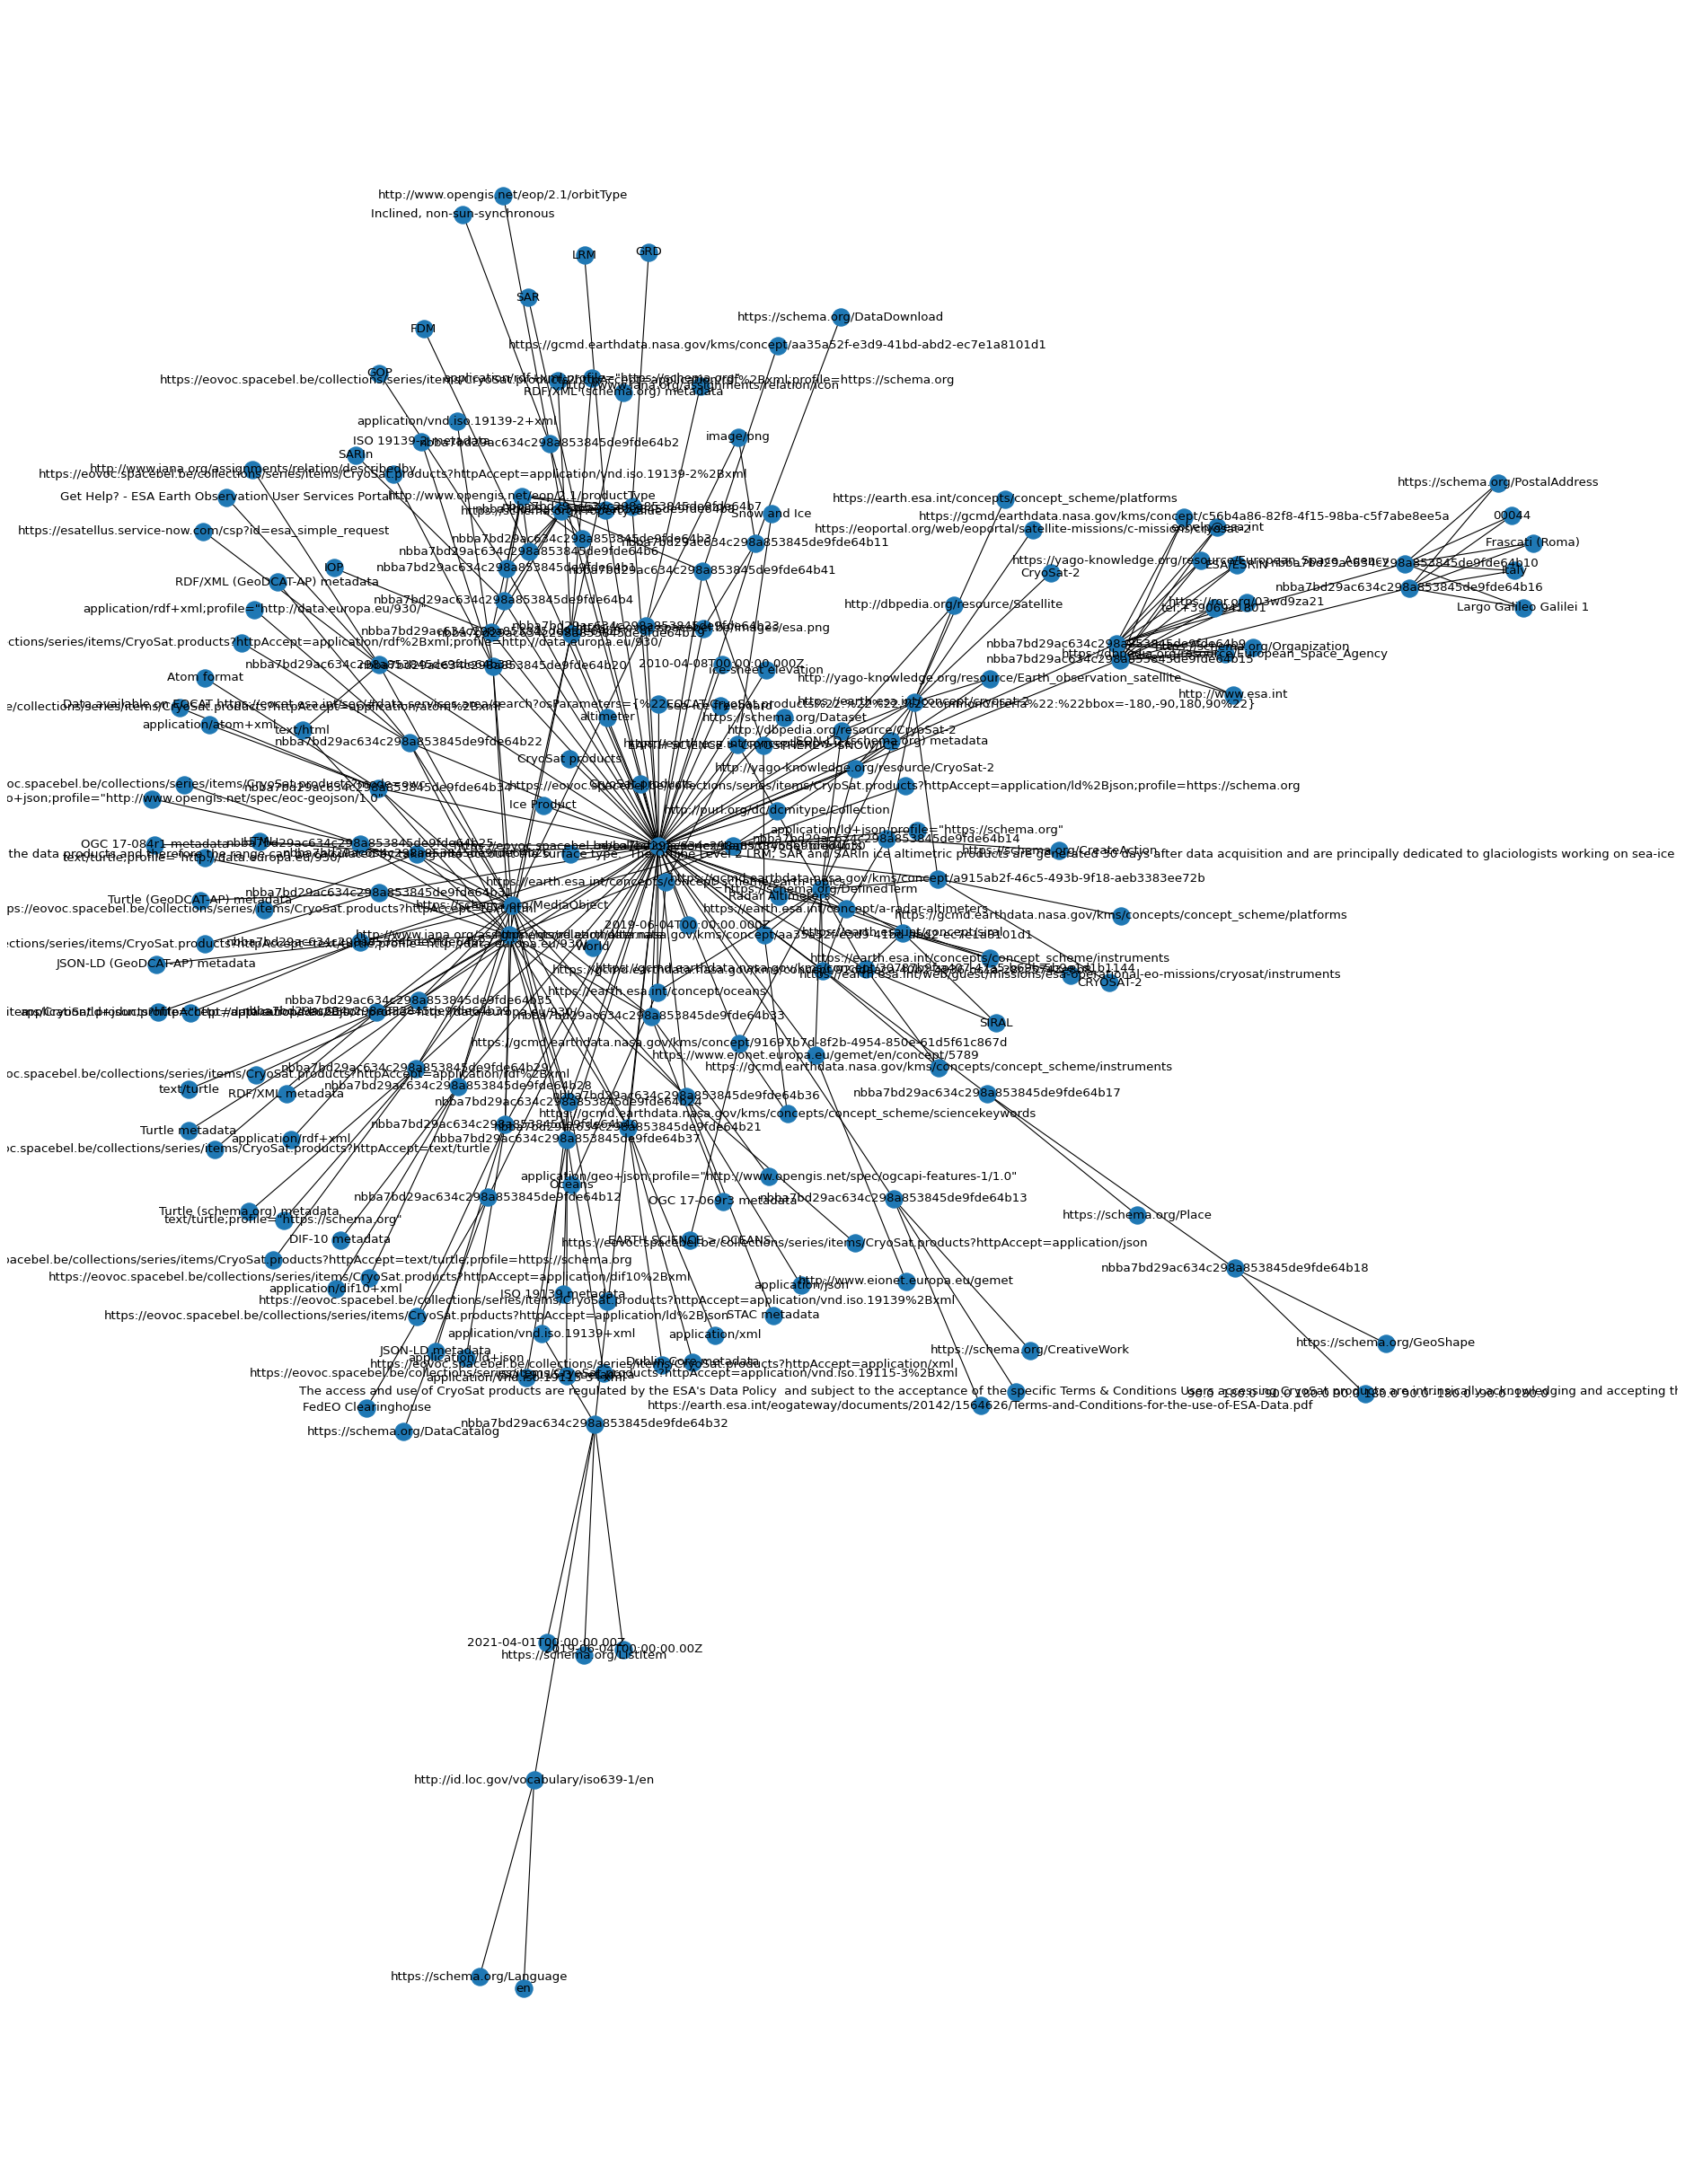

In [10]:
figure(figsize=(30, 40), dpi=80)
rg = rdflib.Graph()
rg.parse(data=response.text, format='ttl', encoding='utf-8')
G = rdflib_to_networkx_graph(rg)
plt.plot()
nx.draw(G, with_labels=True)


<a name='Services'></a>     
## Services   


### Services : Search by identifier  
**Example: 10**  
>  Return @id, name, keywords, ...  
 OK  


In [11]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?name ?kw   
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Service>.         
  ?p schema:name ?name.
  ?p schema:keywords ?kw. 
  ?p schema:identifier "rasdaman".
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,name,kw
0,https://eovoc.spacebel.be/collections/services...,rasdaman - raster data manager,https://gcmd.earthdata.nasa.gov/kms/concept/86...
1,https://eovoc.spacebel.be/collections/services...,rasdaman - raster data manager,http://www.opengis.net/def/serviceType/ogc/wcs...
2,https://eovoc.spacebel.be/collections/services...,rasdaman - raster data manager,https://inspire.ec.europa.eu/metadata-codelist...
3,https://eovoc.spacebel.be/collections/services...,rasdaman - raster data manager,Big Data
4,https://eovoc.spacebel.be/collections/services...,rasdaman - raster data manager,arrays


### Services : Search by name  
**Example: 11**  
>  Return @id, identifier, keywords, ...  
 NOT OK - provider not returned.  


In [12]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?kw  ?id  ?provider 
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Service>.         
  ?p schema:name "SNAP".
  ?p schema:keywords ?kw. 
  ?p schema:identifier ?id.
  ?p schema:provider/schema:name ?provider.
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,kw,id,provider
0,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/visualisation,snap,None
1,https://eovoc.spacebel.be/collections/services...,CEOS,snap,None
2,https://eovoc.spacebel.be/collections/services...,SW and Tools Survey v1.0,snap,None
3,https://eovoc.spacebel.be/collections/services...,Open Source,snap,None
4,https://eovoc.spacebel.be/collections/services...,SAOCOM and Training,snap,None


### Services : Search by provider  
**Example: 12**  
>  Return @id, identifier, keywords, ...  
 OK   


In [13]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?kw  ?id 
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Service>.         
  ?p schema:provider/schema:name "ESA/ESRIN".
  ?p schema:keywords ?kw. 
  ?p schema:identifier ?id.
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,kw,id
0,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/cosmo-skymed,eo-pdgs-datacube
1,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/pleiades,eo-pdgs-datacube
2,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/spot-7,eo-pdgs-datacube
3,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/spot-6,eo-pdgs-datacube
4,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/aura,eo-pdgs-datacube
5,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/landsat-7,eo-pdgs-landsat-datacube
6,https://eovoc.spacebel.be/collections/services...,https://gcmd.earthdata.nasa.gov/kms/concept/86...,eo-pdgs-landsat-datacube
7,https://eovoc.spacebel.be/collections/services...,http://inspire.ec.europa.eu/metadata-codelist/...,eo-pdgs-landsat-datacube
8,https://eovoc.spacebel.be/collections/services...,http://www.opengis.net/def/serviceType/ogc/wcs...,eo-pdgs-landsat-datacube
9,https://eovoc.spacebel.be/collections/services...,https://inspire.ec.europa.eu/metadata-codelist...,eo-pdgs-landsat-datacube


### Services : Search by provider URI  
**Example: 13**  
>  Return @id, identifier, keywords, ...  
 OK   


In [14]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?kw  ?id 
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Service>.         
  ?p schema:provider/schema:sameAs <https://dbpedia.org/resource/European_Space_Agency>.
  ?p schema:keywords ?kw. 
  ?p schema:identifier ?id.
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,kw,id
0,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/cosmo-skymed,eo-pdgs-datacube
1,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/pleiades,eo-pdgs-datacube
2,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/spot-7,eo-pdgs-datacube
3,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/spot-6,eo-pdgs-datacube
4,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/aura,eo-pdgs-datacube
5,https://eovoc.spacebel.be/collections/services...,https://earth.esa.int/concept/landsat-7,eo-pdgs-landsat-datacube
6,https://eovoc.spacebel.be/collections/services...,https://gcmd.earthdata.nasa.gov/kms/concept/86...,eo-pdgs-landsat-datacube
7,https://eovoc.spacebel.be/collections/services...,http://inspire.ec.europa.eu/metadata-codelist/...,eo-pdgs-landsat-datacube
8,https://eovoc.spacebel.be/collections/services...,http://www.opengis.net/def/serviceType/ogc/wcs...,eo-pdgs-landsat-datacube
9,https://eovoc.spacebel.be/collections/services...,https://inspire.ec.europa.eu/metadata-codelist...,eo-pdgs-landsat-datacube


### Services : Describe service in JSON-LD   
  OK.  


In [15]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/services/items/goce-user-toolbox_>
"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/ld+json'})
print(response.text)


{
  "identifier": ["goce-user-toolbox_"],
  "additionalProperty": {
    "@type": "PropertyValue",
    "propertyID": "http://dbpedia.org/resource/Spatial_reference_system",
    "value": "http://www.opengis.net/def/crs/EPSG/0/4326"
  },
  "keywords": [
    {
      "@type": "DefinedTerm",
      "name": "Solid Earth",
      "@id": "https://earth.esa.int/concept/solid-earth",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Oceans",
      "@id": "https://earth.esa.int/concept/oceans",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "SSTI",
      "@id": "https://earth.esa.int/concept/ssti",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "EGG",
      "@id": "https://earth.esa.int/concept/egg",
      "inDefined

### Services : Describe service in RDF/XML   
  OK.  


In [16]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/services/items/goce-user-toolbox_>

"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/rdf+xml'})
print(response.text)


<rdf:RDF
    xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    xmlns:schema="https://schema.org/"
    xmlns:wikidata="http://www.wikidata.org/entity/"
    xmlns:rdfa="http://www.w3.org/ns/rdfa#"
    xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/"
    xmlns:yago="http://yago-knowledge.org/resource/"
    xmlns:dbpedia="http://dbpedia.org/resource/"
    xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
    xmlns:void="http://rdfs.org/ns/void#"
    xmlns:dcterms="http://purl.org/dc/terms/"
    xmlns:dc="http://purl.org/dc/elements/1.1/"
    xmlns:owl="http://www.w3.org/2002/07/owl#"
    xmlns:dctype="http://purl.org/dc/dcmitype/"
    xmlns:eli="http://data.europa.eu/eli/ontology#"
    xmlns:skos="http://www.w3.org/2004/02/skos/core#"
    xmlns:bibo="http://purl.org/ontology/bibo/"
    xmlns:dcat="http://www.w3.org/ns/dcat#"
    xmlns:foaf="http://xmlns.com/foaf/0.1/"
    xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
  <schema:CreativeWork rdf:about="https://eovoc.

### Services : Describe service in Turtle   
  OK.  


In [17]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/services/items/goce-user-toolbox_>

"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'text/turtle'})
print(response.text)


@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl

Display the response as a graph.


In [ ]:
figure(figsize=(30, 40), dpi=80)
rg = rdflib.Graph()
rg.parse(data=response.text, format='ttl', encoding='utf-8')
G = rdflib_to_networkx_graph(rg)
plt.plot()
nx.draw(G, with_labels=True)


<a name='Granules'></a>     
## Granules   


### Granules : Search by platform name, Point of Interest URI  
**Example: 18**  
>  Return @id, identifier, keywords, polygon...  
 OK   


In [18]:
q="""

PREFIX schema: <https://schema.org/>

SELECT ?p ?id ?polygon
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Dataset>.  
  ?p schema:potentialAction/schema:instrument/schema:name "PROBA".        
  ?p schema:spatialCoverage/schema:geoContains <http://yago-knowledge.org/resource/Mount_Etna>.
  ?p schema:spatialCoverage/schema:geo/schema:polygon ?polygon.
  ?p schema:identifier ?id.
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,id,polygon
0,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_HRC_HRC_1P_20210221T131056_N37-076_E0...,37.74 15.03 37.78 15.03 37.78 14.97 37.74 14.97
1,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96
2,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E0...,37.8 14.93 37.68 14.95 37.7 15.1 37.77 15.11
3,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96
4,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E0...,37.67 15.05 37.71 14.89 37.83 14.95 37.82 15.0...


### Granules : Search by WKT geometry (coordinates of mount Etna)  
**Example: 19**  
>  Return @id, polygon, temporal coverage, thumbnail. Use relation and mapping with schema.org as proposed in [GeoSPARQL 1.1](https://opengeospatial.github.io/ogc-geosparql/geosparql11/spec.html#_e_7_schema_org).  
 OK   


In [19]:
q="""

PREFIX schema: <https://schema.org/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

SELECT ?p ?id ?polygon ?time ?preview
WHERE
{
  ?p schema:additionalType <http://purl.org/dc/dcmitype/Dataset>.  
  ?p schema:potentialAction/schema:instrument/schema:name "PROBA".        
  ?p schema:spatialCoverage/schema:geoIntersects/geo:asWKT "POINT(14.995 37.755)"^^geo:wktLiteral.
  ?p schema:spatialCoverage/schema:geo/schema:polygon ?polygon.
  ?p schema:identifier ?id.
  ?p schema:temporalCoverage ?time.
  ?p schema:thumbnailUrl ?preview.
}
LIMIT 5

"""
sparql = SPARQLWrapper("https://eovoc.spacebel.be/sparql")
sparql.setQuery(q)
sparql.setReturnFormat(JSON)
result = sparql.query()
dataframe = load_dataframe(result.response)
dataframe.head(20)


,p,id,polygon,time,preview
0,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_HRC_HRC_1P_20210221T131056_N37-076_E0...,37.74 15.03 37.78 15.03 37.78 14.97 37.74 14.97,2021-02-21T13:10:56Z/2021-02-21T13:10:56Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-HRC/...
1,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_HRC_HRC_1P_20210221T131056_N37-076_E0...,37.74 15.03 37.78 15.03 37.78 14.97 37.74 14.97,2021-02-21T13:10:56Z/2021-02-21T13:10:56Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-HRC/...
2,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96,2016-04-13T14:44:00Z/2016-04-13T14:48:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
3,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96,2016-04-13T14:44:00Z/2016-04-13T14:48:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
4,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E0...,37.8 14.93 37.68 14.95 37.7 15.1 37.77 15.11,2014-06-28T05:06:00Z/2014-06-28T05:10:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
5,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E0...,37.8 14.93 37.68 14.95 37.7 15.1 37.77 15.11,2014-06-28T05:06:00Z/2014-06-28T05:10:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
6,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96,2018-07-05T13:21:00Z/2018-07-05T13:25:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
7,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E0...,37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96,2018-07-05T13:21:00Z/2018-07-05T13:25:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
8,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E0...,37.67 15.05 37.71 14.89 37.83 14.95 37.82 15.0...,2015-12-11T14:57:00Z/2015-12-11T15:01:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...
9,https://eovoc.spacebel.be/collections/datasets...,PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E0...,37.67 15.05 37.71 14.89 37.83 14.95 37.82 15.0...,2015-12-11T14:57:00Z/2015-12-11T15:01:00Z,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...


### Granules : Describe granule in JSON-LD   
  OK.  


In [20]:
q="""

DESCRIBE <https://eovoc.esa.int/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001>
"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/ld+json'})
print(response.text)


{
  "identifier": ["PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001"],
  "additionalProperty": {
    "@type": "PropertyValue",
    "propertyID": "http://dbpedia.org/resource/Spatial_reference_system",
    "value": "http://www.opengis.net/def/crs/EPSG/0/4326"
  },
  "keywords": [],
  "@type": "Dataset",
  "description": "Dataset PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001 from PROBA.CHRIS.1A_TEST acquired 2007-08-04T10:36:00Z",
  "alternateName": "PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001",
  "dateModified": "2022-06-22T15:01:25Z",
  "subjectOf": [
    {
      "@type": "ListItem",
      "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
      "dateModified": "2022-06-22T15:01:25Z"
    },
    {
      "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001.SIP.ZIP_BID.PNG",
      "additionalType": "http://www.iana.org/assignments/relation

### Granules : Describe granule in RDF/XML   
  OK.  


In [21]:
q="""

DESCRIBE <https://eovoc.esa.int/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001>

"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'application/rdf+xml'})
print(response.text)


<rdf:RDF
    xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    xmlns:schema="https://schema.org/"
    xmlns:wikidata="http://www.wikidata.org/entity/"
    xmlns:rdfa="http://www.w3.org/ns/rdfa#"
    xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/"
    xmlns:yago="http://yago-knowledge.org/resource/"
    xmlns:j.0="http://schema.org/"
    xmlns:dbpedia="http://dbpedia.org/resource/"
    xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
    xmlns:void="http://rdfs.org/ns/void#"
    xmlns:dcterms="http://purl.org/dc/terms/"
    xmlns:dc="http://purl.org/dc/elements/1.1/"
    xmlns:owl="http://www.w3.org/2002/07/owl#"
    xmlns:dctype="http://purl.org/dc/dcmitype/"
    xmlns:eli="http://data.europa.eu/eli/ontology#"
    xmlns:skos="http://www.w3.org/2004/02/skos/core#"
    xmlns:bibo="http://purl.org/ontology/bibo/"
    xmlns:dcat="http://www.w3.org/ns/dcat#"
    xmlns:foaf="http://xmlns.com/foaf/0.1/"
    xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
  <schema:Dat

### Granules : Describe granule in Turtle   
  OK.  


In [22]:
q="""

DESCRIBE <https://eovoc.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20070804T103600_N51-024_E004-004_0001>


"""
response = requests.post('https://eovoc.spacebel.be/sparql', data=q , headers={'content-type': 'application/sparql-query', 'Accept': 'text/turtle'})
print(response.text)


@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl

Display the response as a graph.


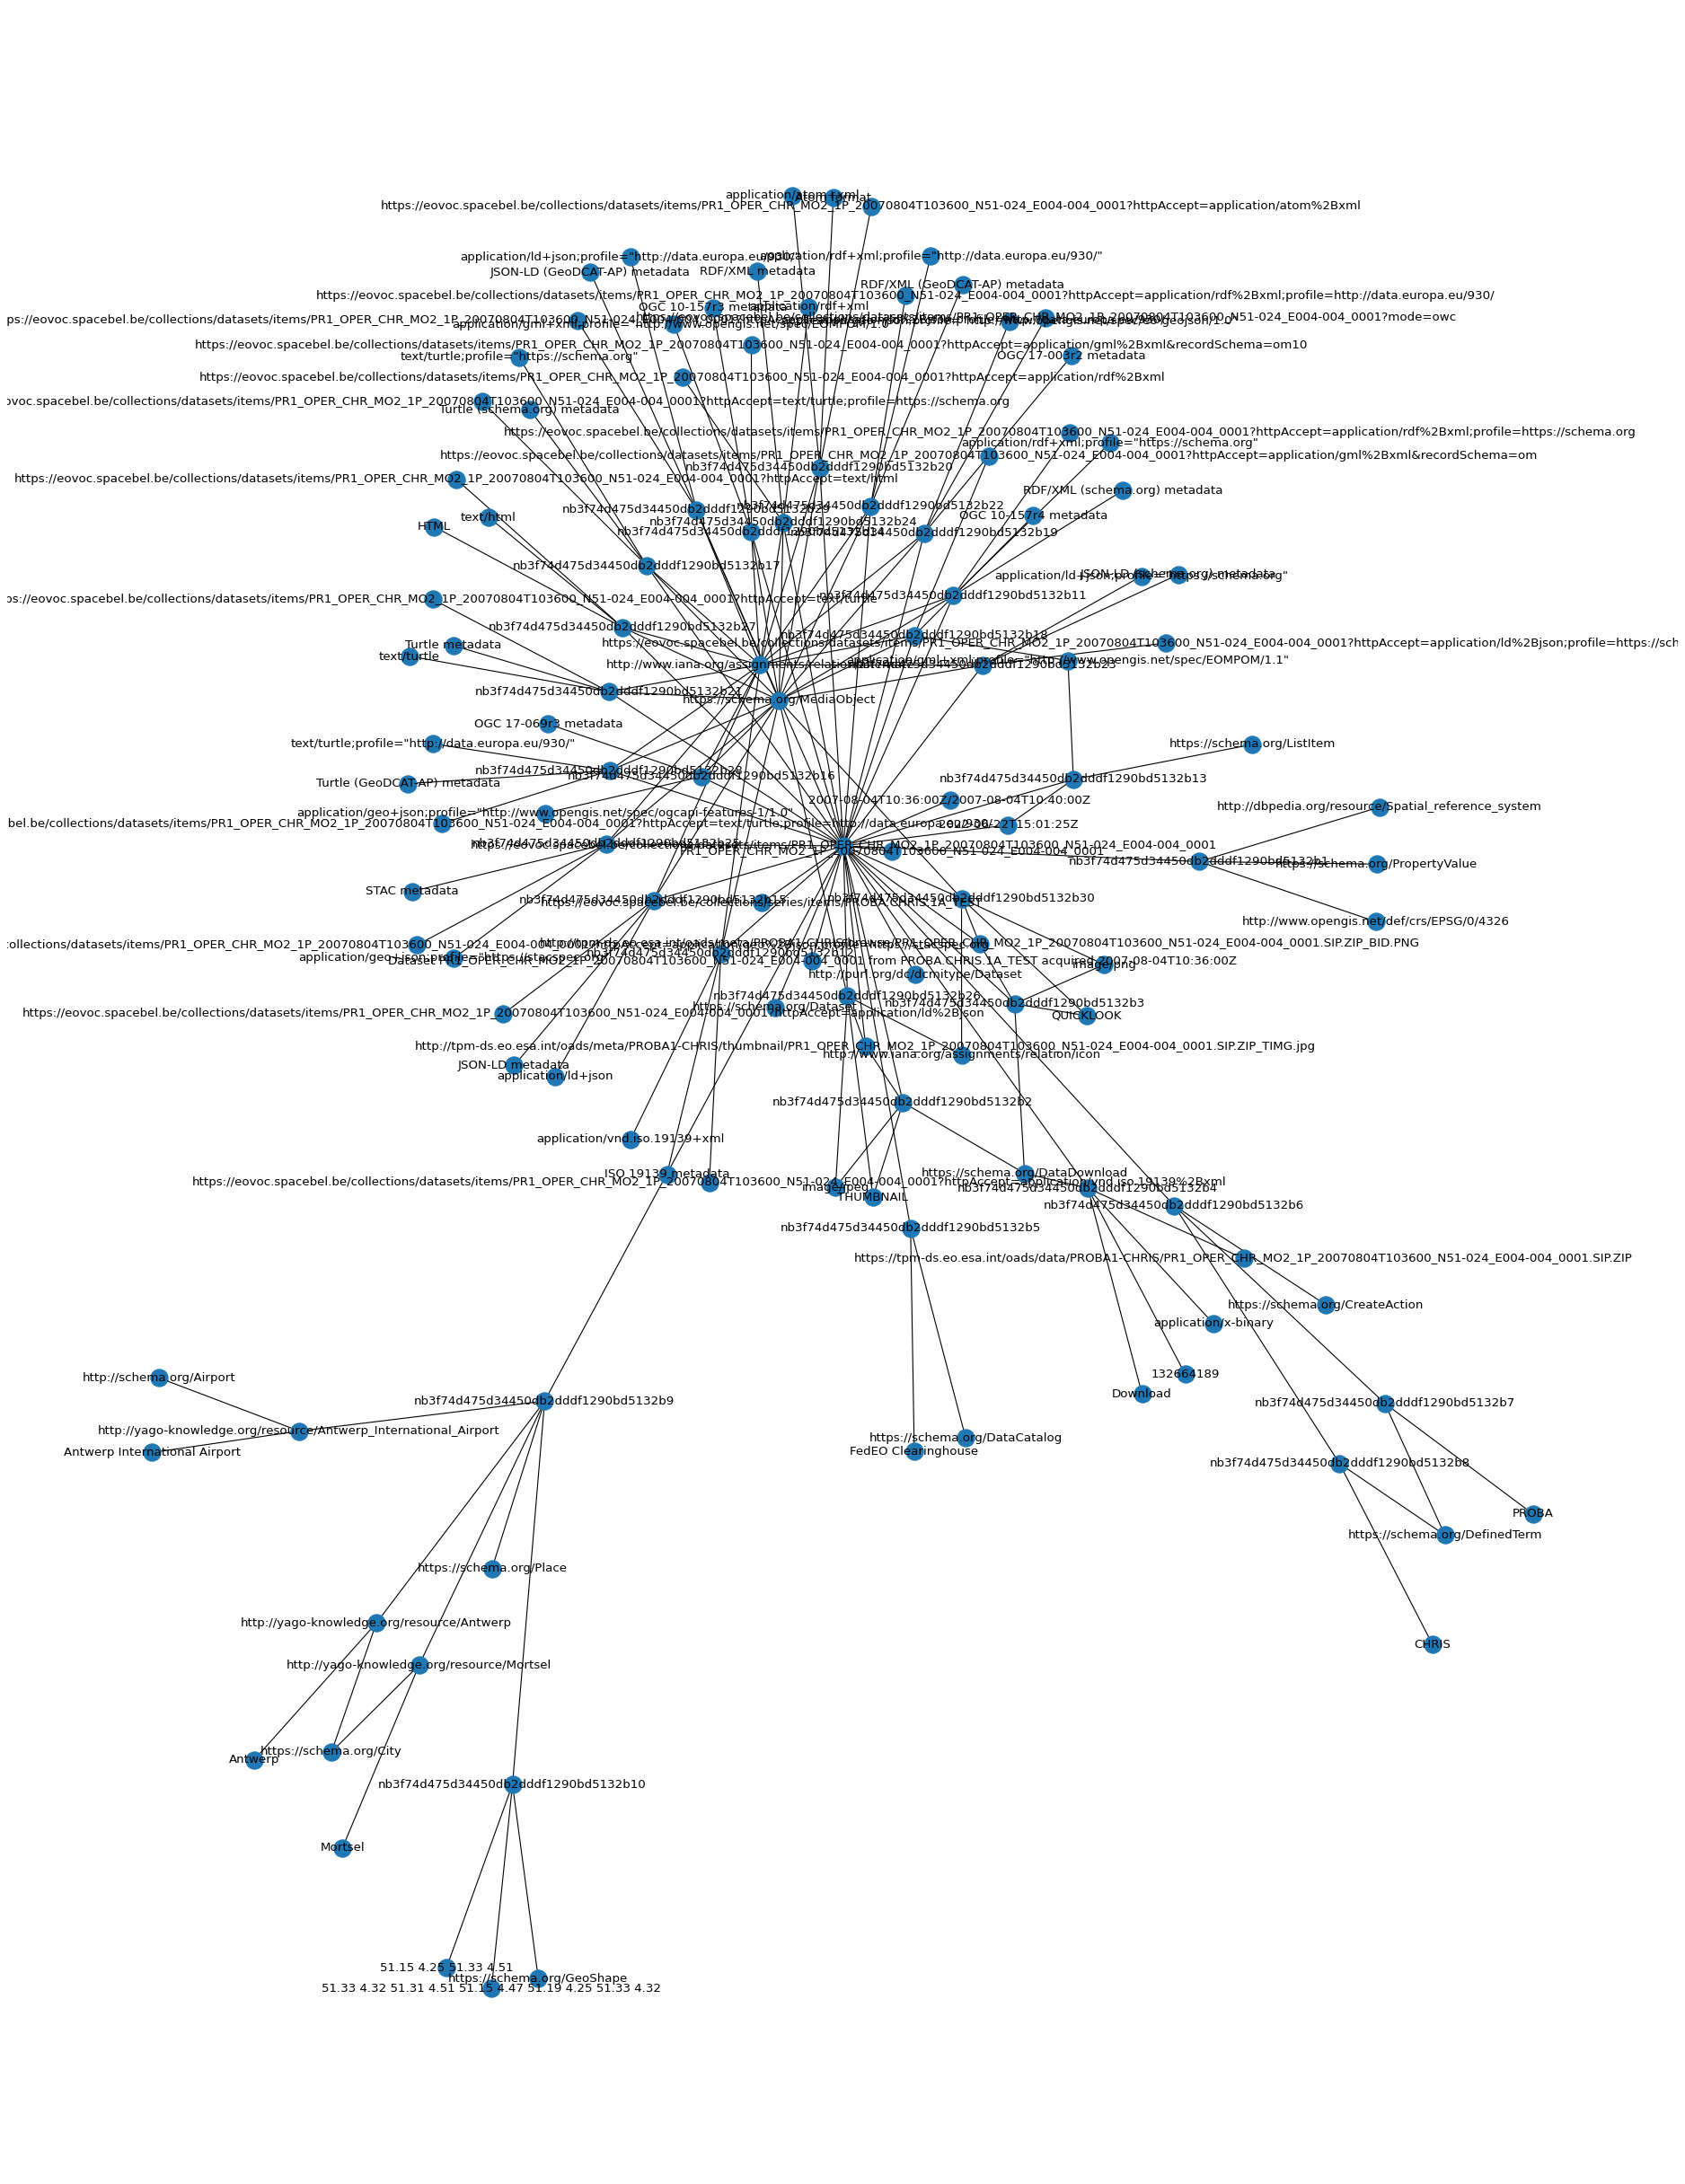

In [23]:
figure(figsize=(30, 40), dpi=80)
rg = rdflib.Graph()
rg.parse(data=response.text, format='ttl', encoding='utf-8')
G = rdflib_to_networkx_graph(rg)
plt.plot()
nx.draw(G, with_labels=True)
